# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [8]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [9]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_author')
feedMe_dir = main_path / 'feed_me' # 기본 feature들 있는 곳
medium_dir =  main_path / 'medium' # 중간 결과물 저장하는 곳
result_dir =  main_path / 'result' # 최종 결과물 저장하는 곳

trn_file = feedMe_dir / 'train.csv'
tst_file = feedMe_dir / 'test_x.csv'
sample_file = feedMe_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [10]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = medium_dir / 'feat' / f'{feature_name}.csv'
p_val_file = medium_dir / 'val' / f'{model_name}.val.csv'
p_tst_file = medium_dir / 'tst' / f'{model_name}.tst.csv'
sub_file = result_dir / f'{model_name}.csv'

In [11]:
train = pd.read_csv(trn_file, encoding = 'utf-8')
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [12]:
test = pd.read_csv(tst_file, encoding = 'utf-8')
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


## Preprocessing

In [13]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [14]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [22]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


In [23]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'sincere wellwisher friend sister lucy odin',
       'wanted lend money', 'certainly not occurred said yes like'],
      dtype=object)

In [16]:
X_train[:3]

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'],
      dtype=object)

## Training

In [17]:
vocab_size = 20000
embedding_dim = 64
max_length = 500
padding_type='post'

In [18]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [19]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [20]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 500) (19617, 500)


In [21]:
trn

array([[  141,  7259,    20, ...,     0,     0,     0],
       [  217,    58,   221, ...,     0,     0,     0],
       [  682,     5,    59, ...,     0,     0,     0],
       ...,
       [ 2407, 19738,   126, ...,     0,     0,     0],
       [  316,  3532,   164, ...,     0,     0,     0],
       [  203,     2,   811, ...,     0,     0,     0]], dtype=int32)

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(.5),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.0003))
    return model

In [24]:
trn.shape[0]

54879

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=3, min_lr=1e-6, mode='min', verbose=1)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            callbacks=[es, rlr])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
1372/1372 [==============================] - 157s 114ms/step - loss: 1.4729 - val_loss: 1.2331
Epoch 2/10
1372/1372 [==============================] - 156s 113ms/step - loss: 1.0702 - val_loss: 0.9432
Epoch 3/10
1372/1372 [==============================] - 161s 117ms/step - loss: 0.8400 - val_loss: 0.8529
Epoch 4/10
1372/1372 [==============================] - 156s 114ms/step - loss: 0.6994 - val_loss: 0.8106
Epoch 5/10
1372/1372 [==============================] - 157s 115ms/step - loss: 0.6057 - val_loss: 0.8226
Epoch 6/10
1372/1372 [==============================] - 156s 113ms/step - loss: 0.5372 - val_loss: 0.8280
Epoch 7/10
1372/1372 [==============================] - ETA: 0s - loss: 0.4789Restoring model weights from the end of the best epoch.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1372/1372 [==============================] - 157s 114ms/step - loss: 0.4789 - val_loss: 0.8430
Epoch 00007: early stopping
t

In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  71.1602%
Log Loss (CV):   0.7819


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [ ]:
# model summary
print(clf.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           1280000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 165, 128)          57472     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 53, 128)           114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

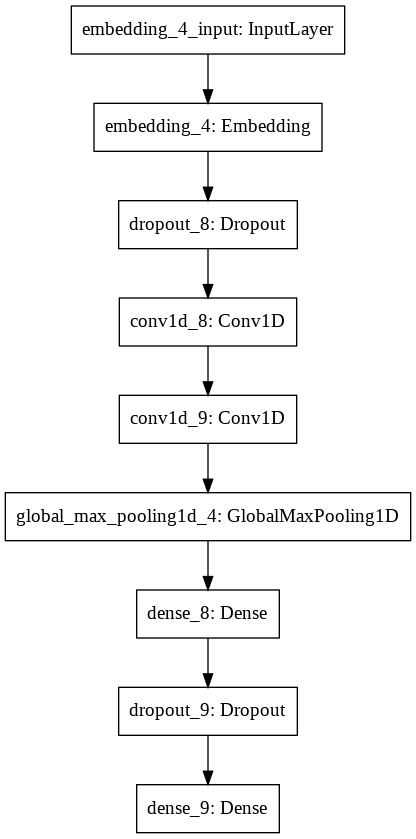

In [ ]:
plot_model(clf)

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [ ]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0253,0.2615,2.8551e-01,4.1296e-01,0.0147
1,0.3199,0.3827,8.0732e-02,3.9797e-02,0.1769
2,0.9984,0.0011,2.1202e-06,6.6506e-07,0.0006
3,0.0021,0.0002,8.0039e-01,1.9521e-03,0.1954
4,0.3766,0.0316,9.5706e-02,4.8054e-02,0.4481


In [ ]:
sub.to_csv(sub_file)